# Aircraft Wildlife Strike Damage Prediction Project

## Goal:
* Discover drivers of damage level in aircraft wildlife strikes, aka bird strikes
* Use those drivers to develop a machine learning model to classify damage level as None/Minor/Substantial/Destroyed (N/M/S/D), as captured in the Federal Aviation Administration (FAA) Wildlife Strike Database
* Damage level definition
    * N (None): No damage was reported
    * M (Minor): Aircraft can be rendered airworthy by simple repairs or replacements and an extensive inspection is not necessary
    * M? (Undetermined): Aircraft was damaged but details were lacking
    * S (Substantial): Aircraft incurs damage or structural failure which adversely affects the structure strength, performance, or flight characteristics of the aircraft and which normally would require major repair or replacement of the affected component. Bent fairings or cowlings; small dents or puncture holes in the skin;  damage to wing tips, antennae, tires or brakes; and engine blade damage not requiring blade replacement are specifically excluded.
    * D (Destroyed): Damage sustained makes it inadvisable to restore the aircraft to an airworthy condition
* This information could be used to assist aircrew, airport managers, and the FAA in mitigating the risk of damaging wildlife strikes

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

from scipy import stats
import math

import warnings
warnings.filterwarnings('ignore')

import wrangle as w
import explore as e
import model as m

np.random.seed(42)

# Acquire
- Data acquired from [FAA](https://wildlife.faa.gov/search). (Open in Access and save as 'strike_reports.csv')
- Alternately, one can download this csv file, current as of May 2023, [here](https://drive.google.com/file/d/13Lee9Ux_FXOhzhHB2WfhPHQRYXUXOyYF/view?usp=sharing)
- It contained 297,947 rows and 100 columns before cleaning
- Each row represents one event where an aircraft struck one or more birds
- Each column represents a variable about a bird strike

# Prepare
- changed all column names to lower_case, changed 'size' to 'size_of_species' (a non-reserved word)
- changed 'incident_date' to 'date', converted it to datetime, and set as index for future time series analysis
- kept 20 of 100 columns
- removed all rows with nulls for mvp
- damage_level had a few values of 'M?' for undetermined. I treated these as nulls and removed them.
- checked that column data types were appropriate
- no outliers removed
- changed precipitation to four True/False columns because the values for this column were combinations of these four things: precip_none, precip_rain, precip_snow, precip_fog
- Encoded categorical variables
- Split data into train, validate, and test (60/20/20), stratifying on damage_level
- Scaled continuous variables
- after preparing the dataframe, it contained 61,955 rows and 23 columns

# Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|damage_level| Level of damage resulting from strike; None / Minor / Substantial / Destroyed|
|time_of_day| Day/Night/Dusk/Dawn|
|airport_id| 4-letter International Civil Aviation Organization (ICAO) identifier for airport, e.g. KSAT|
|airport| Name of airport, e.g. SAN ANTONIO INTL|
|runway| Runway in use at airport, e.g. 12R|
|state| state, e.g. TX|
|opid| operator code (PVT - Private, BUS - Business, SWA - Southwest, etc.)|
|operator| operator name corresponding to opid, e.g. SOUTHWEST AIRLINES|
|aircraft| type of aircraft, e.g. B-737-800|
|ac_class| class of aicraft: A- Airplane / B- Helicopter / C- Glider / J- Ultralight / Y- Other / Z- Unknown|
|ac_mass| mass category of aircraft: 1- 0-2250 kg / 2- 2251-5700 kg / 3- 5701-27000 kg / 4- 27001-272000 kg / 5- >272000 kg|
|type_eng| type of engine: A- piston / B- turbojet / C- turboprop / D- turbofan / E- none (glider) / F- turboshaft (helicopter) / Y- other|
|num_engs| number of engines|
|phase_of_flight| phase of flight in which the strike occurred, e.g. Takeoff|
|speed| speed in nautical miles per hour (knots)|
|species_id| short form representing species of wildlife|
|species| long form for species of wildlife|
|size_of_species| size of species struck, Small / Medium / Large / Unknown|
|num_struck| number of wildlife struck|
|precip_none| 1 if None, else 0|
|precip_rain| 1 if Rain, else 0|
|precip_snow| 1 if Snow, else 0|
|precip_fog| 1 if Fog, else 0|

In [2]:
## acquiring and preparing data for exploration
df = w.wrangle_wildlife_strike_df_mvp()

## splitting data in to train, validate, and test
train, validate, test = w.split_function(df, 'damage_level')

cached csv file found and read
Prepared df: (61955, 23)

Train: (37173, 23)
Validate: (12391, 23)
Test: (12391, 23)


# A brief look at the data

In [3]:
train.head()

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,...,speed,damage_level,species_id,species,size_of_species,num_struck,precip_none,precip_rain,precip_fog,precip_snow
date,,,,,,,,,,,,,,,,,,,,,
2018-03-29,Dusk,KDWH,DAVID WAYNE HOOKS MEMORIAL ARPT,17L,TX,BUS,BUSINESS,PA-46 MALIBU,A,1,...,90.0,N,ZT101,Red-winged blackbird,Small,1,1,0,0,0
1997-04-13,Day,KISP,LONG ISLAND MAC ARTHUR,24,NY,GAA,BUSINESS EXPRESS,SAAB-340,A,3,...,60.0,N,O2205,Mourning dove,Small,1,1,0,0,0
2010-10-31,Night,KEWR,NEWARK LIBERTY INTL ARPT,4R,NJ,COA,CONTINENTAL AIRLINES,B-737-800,A,4,...,155.0,N,UNKBS,Unknown bird - small,Small,1,1,0,0,0
2004-07-24,Day,KLAW,LAWTON-FORT SILL REGIONAL ARPT,35,OK,EGF,AMERICAN EAGLE AIRLINES,SAAB-340,A,3,...,130.0,N,UNKBS,Unknown bird - small,Small,1,1,0,0,0
2001-10-14,Night,PHLI,LIHUE ARPT,35,HI,HAL,HAWAIIAN AIR,B-717-200,A,4,...,80.0,N,N5122,Pacific golden-plover,Small,2-10,1,0,0,0


## A summary of the data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37173 entries, 2018-03-29 to 1998-08-27
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time_of_day      37173 non-null  object 
 1   airport_id       37173 non-null  object 
 2   airport          37173 non-null  object 
 3   runway           37173 non-null  object 
 4   state            37173 non-null  object 
 5   opid             37173 non-null  object 
 6   operator         37173 non-null  object 
 7   aircraft         37173 non-null  object 
 8   ac_class         37173 non-null  object 
 9   ac_mass          37173 non-null  int64  
 10  type_eng         37173 non-null  object 
 11  num_engs         37173 non-null  int64  
 12  phase_of_flight  37173 non-null  object 
 13  speed            37173 non-null  float64
 14  damage_level     37173 non-null  object 
 15  species_id       37173 non-null  object 
 16  species          37173 non-null  object 


In [5]:
train.describe()

,ac_mass,num_engs,speed,precip_none,precip_rain,precip_fog,precip_snow
count,37173.000000,37173.000000,37173.000000,37173.000000,37173.000000,37173.000000,37173.000000
mean,3.514164,2.016168,139.896188,0.919834,0.056116,0.023565,0.003954
std,0.886060,0.412703,43.087486,0.271553,0.230149,0.151693,0.062761
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,120.000000,1.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,138.000000,1.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,155.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,4.000000,650.000000,1.000000,1.000000,1.000000,1.000000


# Explore

## What is the distribution of the target?

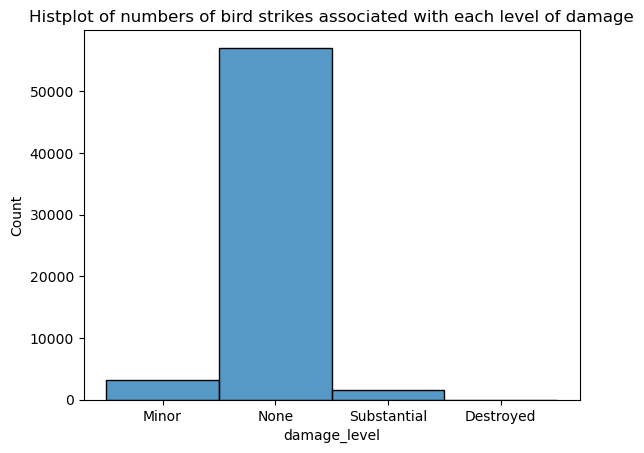

In [6]:
# visualize the distribution of damage levels (univariate visualization so looking at entire df)
e.get_target_dist(df, 'damage_level')

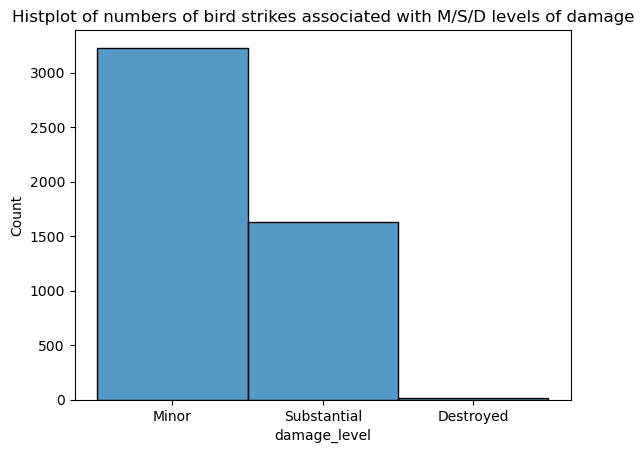

In [7]:
# most birdstrikes result in negligible damage, so plotting the distribution of just M/S/D to see it better
e.get_target_dist_MSD(df[df.damage_level != 'N'], 'damage_level')

## Question 1. Is damage_level associated with size_of_species?

### Visualize

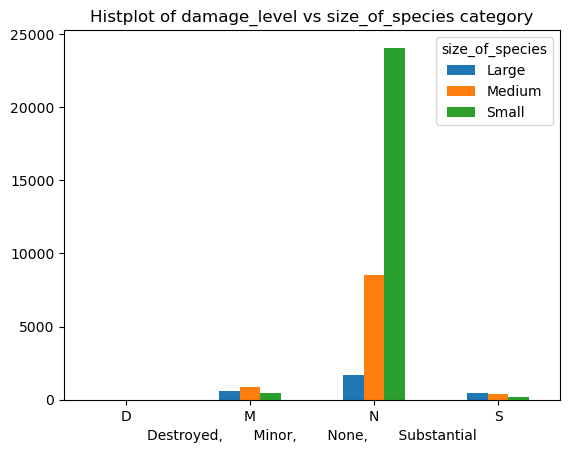

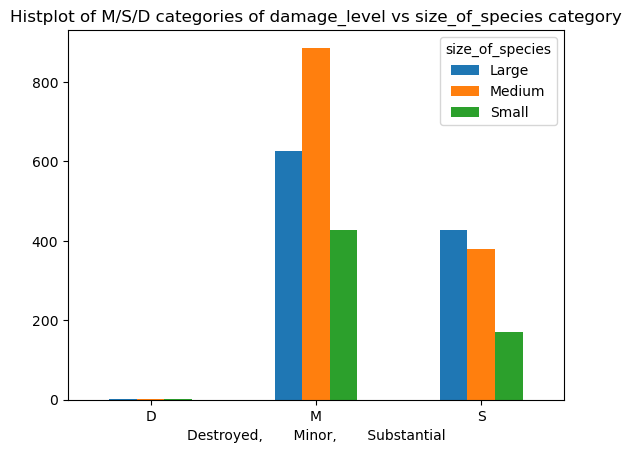

In [8]:
# visualize distribution of damage levels vs size_of_species
e.get_damage_catfeature_plot(train, 'size_of_species')

### Analyze size_of_species vs damage_level with statistics
- $H_0$ There is NO relationship between size_of_species and damage_level
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs categorical => chi^2 test

In [9]:
# get crosstabs of observed and expected damage levels related to size_of_species and chi2 test
e.get_chi2(train, 'size_of_species')

---- Observed Crosstab ----


size_of_species,Large,Medium,Small
damage_level,,,
D,3,3,1
M,626,886,426
N,1682,8499,24070
S,427,380,170


---- Expected Crosstab from chi2 test ----


size_of_species,Large,Medium,Small
damage_level,,,
D,1,2,5
M,143,509,1286
N,2523,9000,22728
S,72,257,648


chi2 = 5056.543424290582,  p = 0.0,  degf = 6


### Summarize size_of_species vs damage_level

- p is < .05, so we can reject the null hypothesis which suggests the $H_a$
- In summary, there is an association between size_of_species and damage_level
    * Large and medium sized birds = Higher Damage Levels
    * Small birds result in less damage

## Question 2. Is damage_level associated with speed

### Visualize

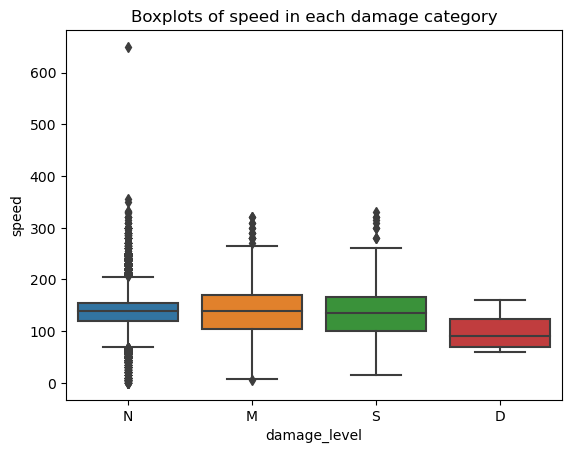

In [10]:
# get boxplots of speed in the different damage categories N/M/S/D
sns.boxplot(data=train, x='damage_level', y='speed')
plt.title('Boxplots of speed in each damage category')
plt.show()

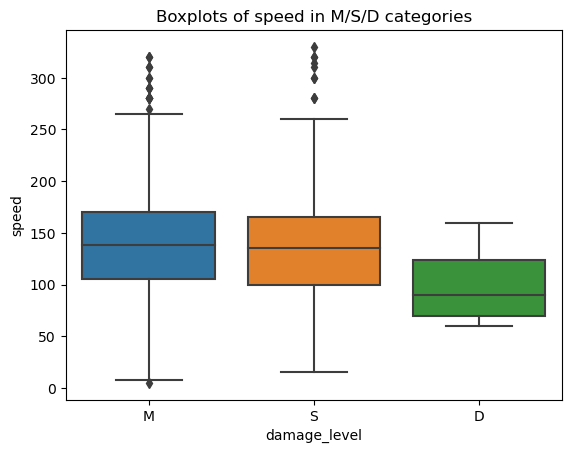

In [11]:
# boxplots of speed of only the M/S/D damage levels
sns.boxplot(data=train[train.damage_level != 'N'], x='damage_level', y='speed')
plt.title('Boxplots of speed in M/S/D categories')
plt.show()

### Analyze damage_level vs speed with statistics
- $H_0$ There is NO relationship between damage_level and speed
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs continuous, normally distributed, > 2 groups, equal variance => ANOVA

In [12]:
# get ANOVA stats test results
stats.f_oneway(train[train.damage_level == 'D'].speed, train[train.damage_level == 'S'].speed
               , train[train.damage_level == 'M'].speed, train[train.damage_level == 'N'].speed)

F_onewayResult(statistic=3.011229012721705, pvalue=0.028859123501074564)

### Summarize damage_level vs speed

- p is < .05, so we can reject the null hypothesis which suggests the $H_a$
- In summary, there is an association between damage_level and speed
    * The difference is slight, and it's unexpected, i.e. slower speeds are more likely to result in greater damage
        * my guess is that this is because smaller aircraft are more likely to sustain damage and they generally fly at slower speeds


## Question 3. Is damage_level associated with ac_mass?

### Visualize

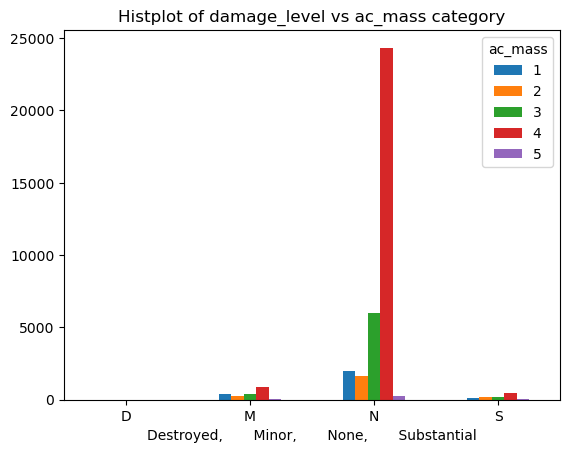

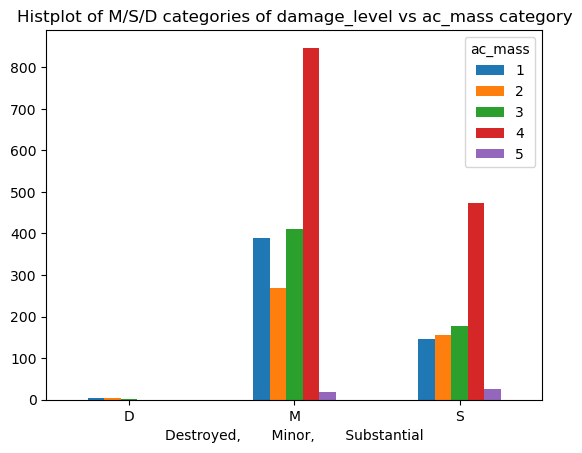

In [13]:
# visualize distribution of damage levels vs ac_mass
e.get_damage_catfeature_plot(train, 'ac_mass')

### Analyze damage_level vs ac_mass with statistics
- $H_0$ There is NO relationship between damage_level and ac_mass
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs categorical => chi^2 test

In [14]:
# get crosstabs of observed and expected damage levels related to ac_mass and chi2 test
e.get_chi2(train, 'ac_mass')

---- Observed Crosstab ----


ac_mass,1,2,3,4,5
damage_level,,,,,
D,3,3,1,0,0
M,390,270,412,847,19
N,1980,1672,6008,24341,250
S,145,156,177,474,25


---- Expected Crosstab from chi2 test ----


ac_mass,1,2,3,4,5
damage_level,,,,,
D,0,0,1,5,0
M,131,110,344,1338,15
N,2320,1936,6079,23645,271
S,66,55,173,674,8


chi2 = 1459.789170467366,  p = 1.7820089879603714e-305,  degf = 12


### Summarize damage_level vs ac_mass

- p is < .05, so we can reject the null hypothesis which suggests the $H_a$
- In summary, there is an association between damage_level and ac_mass
    * smaller aircraft (categories 1,2,3) generally had higher damage levels
    * category 4 (most airline aircraft) aircraft had less damage
    * category 5 aircraft (> 272,000 kg) had slightly more damage, but the total number of strikes is much smaller (<300), i.e. there's less data to work with

## Question 4. Is damage_level associated with ac_class?

### Visualize

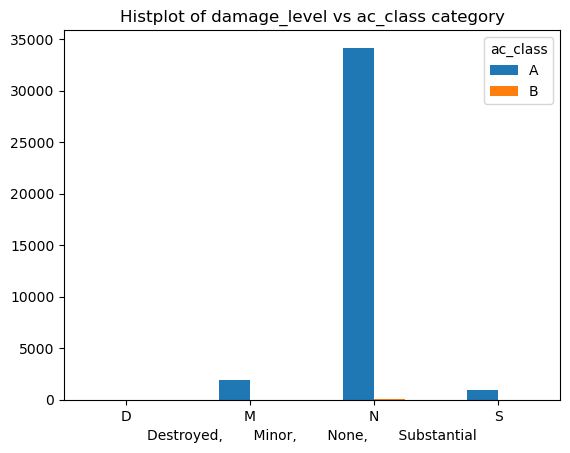

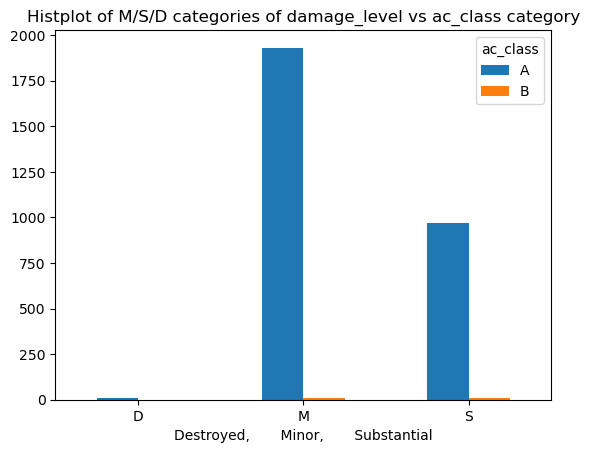

In [15]:
# visualize distribution of damage levels vs ac_class (airplane, helicopter)
e.get_damage_catfeature_plot(train, 'ac_class')

### Analyze damage_level vs ac_class with statistics
- $H_0$ There is NO relationship between damage_level and ac_class
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs categorical => chi^2 test

In [16]:
# get crosstabs of observed and expected damage levels related to ac_mass and chi2 test
e.get_chi2(train, 'ac_class')

---- Observed Crosstab ----


ac_class,A,B
damage_level,,
D,7,0
M,1931,7
N,34159,92
S,967,10


---- Expected Crosstab from chi2 test ----


ac_class,A,B
damage_level,,
D,7,0
M,1932,6
N,34151,100
S,974,3


chi2 = 18.860447860258095,  p = 0.0002921772227948457,  degf = 3


### Summarize damage_level vs ac_class

- p is < .05, so we can reject the null hypothesis which suggests the $H_a$
- In summary, there is an association between damage_level and ac_class
    * Helicopters are more likely to sustain substantial damage
    * Airplanes experience damage close to expected, though

# Question 5. Is damage_level associated with type_eng ?

### Visualize

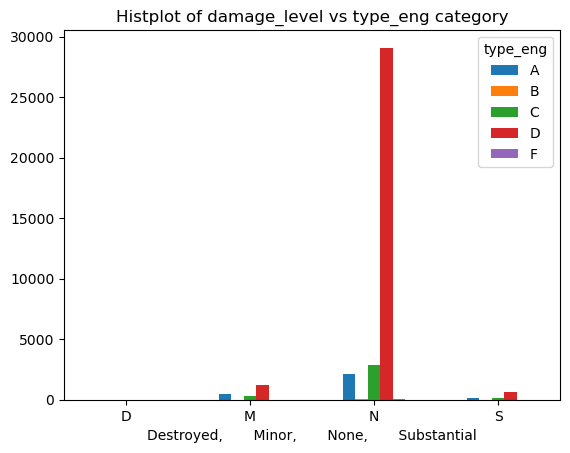

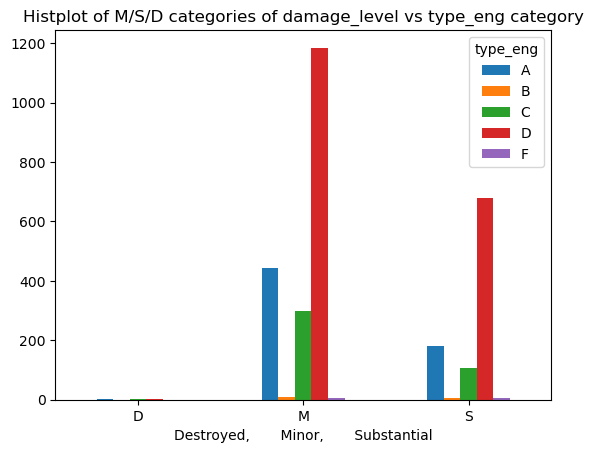

In [17]:
# visualize distribution of damage levels vs type_eng
e.get_damage_catfeature_plot(train, 'type_eng')

### Analyze damage_level vs type_eng with statistics
- $H_0$ There is NO relationship between damage_level type_eng charges
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs categorical => chi^2 test

In [18]:
# get crosstabs of observed and expected damage levels related to type_eng and chi2 test
e.get_chi2(train, 'type_eng')

---- Observed Crosstab ----


type_eng,A,B,C,D,F
damage_level,,,,,
D,4,0,1,2,0
M,442,9,297,1185,5
N,2146,49,2897,29078,81
S,180,6,107,679,5


---- Expected Crosstab from chi2 test ----


type_eng,A,B,C,D,F
damage_level,,,,,
D,1,0,1,6,0
M,145,3,172,1613,5
N,2554,59,3042,28512,84
S,73,2,87,813,2


chi2 = 1135.7407205337056,  p = 1.1828641050469783e-235,  degf = 12


### Summarize damage_level vs type_eng

- p is < .05, so we can reject the null hypothesis which suggests the $H_a$
- In summary, there is an association between damage_level and type_eng
    * Categories: A: piston engine, B: turbojet, C: turboprop, D: turbofan (most airline passenger jets), F: turboshaft (helicopter)
    * Categories A/B/C and F are more likely to be damaged
    * Category D (turbofan) are less likely to be damaged

# Question 6. Is damage_level associated with num_engs ?

### Visualize

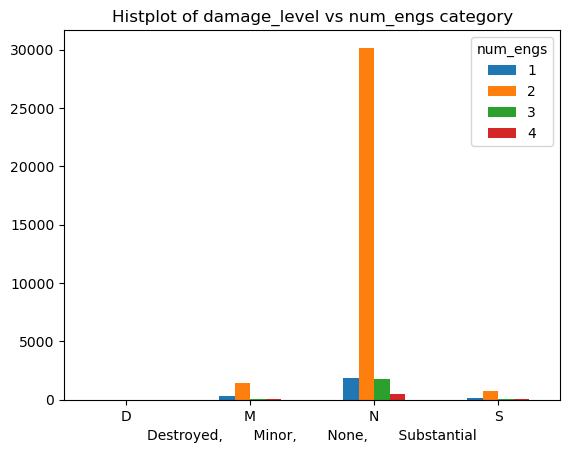

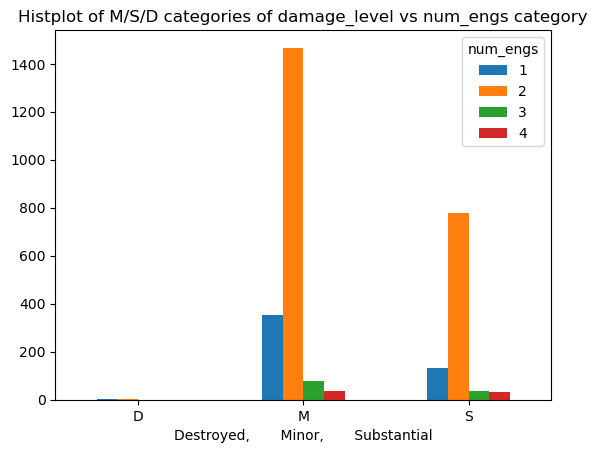

In [19]:
# visualize distribution of damage levels vs num_engs
e.get_damage_catfeature_plot(train, 'num_engs')

### Analyze damage_level vs num_engs with statistics
- $H_0$ There is NO relationship between damage_level and num_engs
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs categorical => chi^2 test

In [20]:
# get crosstabs of observed and expected damage levels related to num_engs and chi2 test
e.get_chi2(train, 'num_engs')

---- Observed Crosstab ----


num_engs,1,2,3,4
damage_level,,,,
D,3,4,0,0
M,355,1467,78,38
N,1854,30162,1780,455
S,132,777,35,33


---- Expected Crosstab from chi2 test ----


num_engs,1,2,3,4
damage_level,,,,
D,0,6,0,0
M,122,1690,99,27
N,2160,29862,1744,485
S,62,852,50,14


chi2 = 664.0679344684685,  p = 3.652271155556935e-137,  degf = 9


### Summarize damage_level vs num_engs

- p is < .05, so we can reject the null hypothesis which suggests the $H_a$
- In summary, there is an association between damage_level and num_engs
    * Having 1 or 4 engines is more likely to result in damage
    * Having 2 or 3 engines is less likely to result in damage

# Exploration Summary
I will move to modeling with the following features:
- size_of_species
- speed
- ac_mass
- ac_class
- type_eng
- num_engs
- time_of_day
- phase_of_flight
- precipitation (precip_none/rain/snow/fog)
- num_struck


The following features will have a LOT of categories. I may go back and bin them, but not for MVP:
- state
- airport_id
- aircraft
- species_id
- runway
- operator

# Modeling
* Evaluation Metrics
    * I will use accuracy for evaluating models
* The average target is 'N' which is the baseline prediction
* I will evaluate 4 different model types and various hyperparameter configurations
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

In [21]:
## prep data for modeling (encoding categorical columns)
model_df = w.prep_w_strike_df_for_modeling_mvp(df)
train, validate, test = w.split_function(model_df, 'damage_level')

# split into X, y for modeling
X_train, X_validate, X_test, y_train, y_validate, y_test, baseline_accuracy = m.get_X_y_baseline(train
                                                                                                 , validate
                                                                                                 , test
                                                                                                 , 'damage_level')

# scaling continuous variable columns for use in modeling   (only one column in this case, 'speed')
X_train_scaled, X_validate_scaled, X_test_scaled = w.get_minmax_scaled(X_train
                                                                       , X_validate
                                                                       , X_test
                                                                       , ['speed'])

Prepared df: (61955, 31)

Train: (37173, 31)
Validate: (12391, 31)
Test: (12391, 31)


In [22]:
# print baseline accuracy
print(f'Baseline (damage_level == "N") =   {baseline_accuracy}')

Baseline (damage_level == "N") =   0.9213945605681543


## Model 1: Logistic Regression

In [23]:
# get model results
results_df = m.get_multi_logit_scores(X_train_scaled, X_validate_scaled, y_train, y_validate)
results_df

,C,train_acc,val_acc,coef_speed,coef_precip_none,coef_precip_rain,coef_precip_snow,coef_precip_fog,coef_ac_mass,coef_num_engs,...,coef_phase_of_flight_Descent,coef_phase_of_flight_En Route,coef_phase_of_flight_Landing Roll,coef_phase_of_flight_Local,coef_phase_of_flight_Parked,coef_phase_of_flight_Take-off Run,coef_phase_of_flight_Taxi,coef_num_struck_11-100,coef_num_struck_2-10,coef_num_struck_More than 100
0,0.01,0.921771,0.921314,-0.003668,-0.002756,-0.00487,-0.000419,0.007964,-0.094135,-0.024113,...,-0.000541,0.0,0.002344,-0.000114,-0.000007,0.020158,-0.000135,0.009233,-0.013472,-0.000022
0,0.1,0.922094,0.921152,-0.038544,-0.184467,-0.098303,-0.011496,0.0955,-0.501513,-0.205578,...,-0.005116,0.0,-0.001718,-0.002731,-0.000099,0.222724,-0.003829,0.123253,-0.173958,-0.000265
0,1.0,0.922444,0.920668,-0.084911,-0.713634,-0.211996,-0.024099,0.220146,-0.704214,-0.433759,...,-0.00705,0.0,-0.066364,-0.007977,-0.000313,0.48304,-0.011821,0.278564,-0.37256,-0.000394
0,10.0,0.922444,0.920668,-0.085682,-0.754389,-0.215158,-0.024005,0.237229,-0.700943,-0.422105,...,-0.00704,0.0,-0.070245,-0.008488,-0.000346,0.519279,-0.012555,0.294695,-0.388523,-0.000387
0,100.0,0.922417,0.920588,-0.087244,-0.752989,-0.219132,-0.024707,0.234906,-0.723801,-0.435558,...,-0.007188,0.0,-0.070627,-0.00847,-0.000342,0.51544,-0.012494,0.294939,-0.38986,-0.000405
0,1000.0,0.922417,0.920507,-0.090101,-0.782214,-0.223709,-0.025161,0.240338,-0.739481,-0.453541,...,-0.00728,0.0,-0.073672,-0.008702,-0.000352,0.526168,-0.012883,0.301098,-0.399985,-0.000407


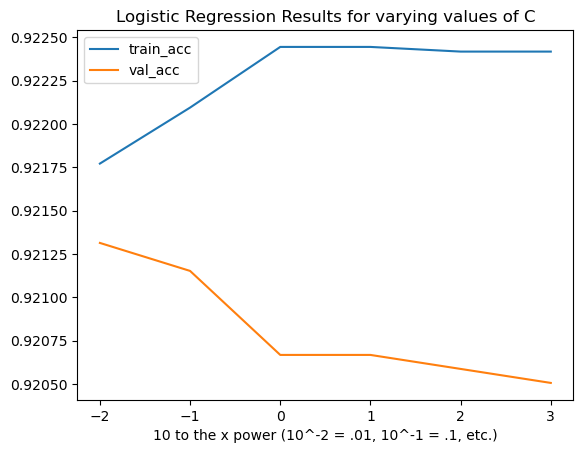

In [24]:
# visualize model results
m.plot_logit_results(results_df)

* Best Logistic Regression model had hyperparameter C = .01 
* Accuracy on train/validate = .921771 / .921314
* This does not beat baseline of .921395

## Model 2: Decision Tree

In [25]:
# get model results
results_df = m.get_dtree_scores(X_train_scaled, X_validate_scaled, y_train, y_validate, crit='gini', max_d=10)
results_df

,max_depth,train_acc,val_acc,difference
1,1,0.921395,0.921395,0.000000
2,2,0.921395,0.921395,0.000000
3,3,0.921395,0.921395,0.000000
4,4,0.921798,0.921556,0.000242
5,5,0.921825,0.921072,0.000753
6,6,0.923089,0.920991,0.002098
7,7,0.924273,0.919458,0.004815
8,8,0.925726,0.920426,0.005300
9,9,0.927958,0.917037,0.010922
10,10,0.930918,0.915907,0.015011


* Best Decision Tree model had hyperparameter max_depth = 4 
* Accuracy on train/validate = .921798 / .921556
* This beat the baseline of .921395, but barely

## Model 3: KNN

In [26]:
# get model results
results_df = m.get_knn_metrics(X_train_scaled, X_validate_scaled, y_train, y_validate, weights_='uniform', max_n=5)
results_df

,train_acc,val_acc
1,0.929707,0.875878
2,0.900627,0.866032
3,0.929922,0.910096
4,0.927743,0.908321
5,0.928362,0.916149


* KNN did not beat baseline

## Model 4: Random Forest

In [27]:
# get model results (takes 30-40" to run)
results_df = m.get_rf_scores(X_train_scaled, X_validate_scaled, y_train, y_validate, m_depth_range=10, m_s_leaf_range=10)
results_df

,min_samples_leaf,trn_acc_depth_1,val_acc_depth_1,diff_1,trn_acc_depth_2,val_acc_depth_2,diff_2,trn_acc_depth_3,val_acc_depth_3,diff_3,...,diff_7,trn_acc_depth_8,val_acc_depth_8,diff_8,trn_acc_depth_9,val_acc_depth_9,diff_9,trn_acc_depth_10,val_acc_depth_10,diff_10
0,1,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000054,0.921852,0.921556,0.000296,0.923385,0.921556,0.001829,0.925591,0.921152,0.004439
1,2,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000027,0.921664,0.921556,0.000108,0.922255,0.921395,0.000861,0.923520,0.921233,0.002287
2,3,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921475,0.921475,0.000000,0.922094,0.921475,0.000619,0.922767,0.921395,0.001372
3,4,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921421,0.921395,0.000027,0.922040,0.921637,0.000404,0.922040,0.921637,0.000404
4,5,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921395,0.921475,-0.000081,0.921717,0.921556,0.000161,0.921959,0.921637,0.000323
5,6,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921448,0.921475,-0.000027,0.921664,0.921556,0.000108,0.921798,0.921637,0.000161
6,7,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921448,0.921475,-0.000027,0.921610,0.921395,0.000215,0.921771,0.921637,0.000135
7,8,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921448,0.921395,0.000054,0.921556,0.921395,0.000161,0.921690,0.921556,0.000135
8,9,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921395,0.921395,0.000000,0.921395,0.921395,0.000000,0.921664,0.921556,0.000108
9,10,0.921395,0.921395,0.0,0.921395,0.921395,0.0,0.921395,0.921395,0.0,...,0.000000,0.921395,0.921395,0.000000,0.921529,0.921395,0.000135,0.921502,0.921395,0.000108


* Best Random Forest Model had hyperparameter max_depth = 9 and min_samples_leaf = 1
* Accuracy on train/validate = .923385 / .921637
* This beat the baseline of .921395, but barely.

## Comparing Models
* No model performed significantly better than the baseline of simply predicting 'N' for damage level
* I will move forward with the Random Forest model on test for the sake of rubric completion

## Best Model (Random Forest) on Test

In [28]:
m.get_best_rf(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test)

Accuracy on test = 0.9214752643047374


## Modeling Summary
* Best model performed nearly identical to baseline
* Baseline accuracy: .921395
* Best Model accuracy on test: .921475

# Conclusions

## Exploration
* The vast majority of bird strikes cause no damage (>90%)
* Larger wildlife are associated with greater damage levels
* Smaller aircraft generally incurred greater damage than larger aircraft
* Slower speeds are associated with greater damage -- requires more investigation. My initial hypothesis is that most bird strikes occur at lower altitudes when generally, aircraft are flying at lower airspeeds. It could also be that bird strikes are more likely to cause damage to smaller aircraft (such as a Cessna-172) which are flying at lower airspeeds generally than larger aircraft like Boeing 737s.
* Helicopters are more likely to incur damage than airplanes

## Modeling
* Most models were able to match baseline, but none were appreciably better

## Recommendations
* For pilots, smaller aircraft are more at risk for bird strike hazards. Most private pilots are flying small aircraft, and they should pay greater attention to bird watch conditions. When checking the weather and the NOTAMS, check the bird condition as well. If your local airport doesn't broadcast this, check www.usahas.com
* For airport managers, pair data from this database with bird mitigation efforts to analyze effectiveness. The FAA in combination with the USDA have excellent recommendations for hazard mitigation, but each airport has specific hazards which can change over time. Vigilance is required.

## Next steps
* Run modeling on a subset of the dataset that includes only damage levels of M, S, or D to see if better performance can be attained
* Go back and handle nulls differently (change nulls to some version of 'Unknown') to get a better value for number of strikes over time; then:
    * Conduct a time series analysis to see what times of year are more likely to incur damaging bird strikes
* Gather more data, such as a measure of the number of aircraft operations (e.g. daily takeoffs and landings, daily number of flights); then:
    * feature engineer a column such as rate of strikes per number of operations/flights
* Consider developing models for specific airports